# Fresh take

## 1. Initalize sites

In [51]:
import os
import os
import shutil
import dbPipeline
import importlib
import time
importlib.reload(dbPipeline)

projectPath = os.path.join(os.getcwd(),'test')

try:
    shutil.rmtree(projectPath)
except:
    pass

db = dbPipeline.database(projectPath=projectPath)
db.projectInventory()
# time.sleep(.25)
Sites = r'example_data\projectInventory_Template.yml'
db.projectInventory(newSites=Sites)


In [53]:
importlib.reload(dbPipeline)

db = dbPipeline.database(projectPath=projectPath)
db.rawFileSearch('SCL','Flux',sourcePath='example_data',wildcard='*Flux*.dat',parserKwargs={'timezone':'UTC',
    'readData':True,'calcStats':True,})

parserKwargs = {'timezone':'UTC',
    'variableMap':{
    'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 5)':{
        'safeName':'TS_1_1_1',
        'unit':'deg C'},
    'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 25)':{
        'safeName':'TS_2_1_1',
        'unit':'deg C'},
    'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 50)':{
        'safeName':'TS_3_1_1',
        'unit':'deg C'},
    'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 100)':{
        'safeName':'TS_4_1_1',
        'unit':'deg C'},
    },}
db.rawFileSearch('SCL','SSM_Profile',sourcePath='example_data',wildcard='*SSM*.csv',parserKwargs=parserKwargs)

parserKwargs = {'timezone':'UTC',
    'variableMap': {'Temp, °C (LGR S/N: 20750527, SEN S/N: 20750527, LBL: 5)': {'safeName': 'TS_1_2_1',
   'unit': 'deg C',},
  'Temp, °C (LGR S/N: 20750527, SEN S/N: 20750527, LBL: 25)': {'safeName': 'TS_2_2_1',
   'unit': 'deg C',},
  'Temp, °C (LGR S/N: 20750527, SEN S/N: 20750527, LBL: 50)': {'safeName': 'TS_3_2_1',
   'unit': 'deg C',},
  'Temp, °C (LGR S/N: 20750527, SEN S/N: 20750527, LBL: 100)': {'safeName': 'TS_4_2_1',
   'unit': 'deg C',}}}
db.rawFileSearch('SCL','WSM_Profile',sourcePath='example_data',wildcard='*WSM*.csv',parserKwargs=parserKwargs)



c:\Users\User\GSC_Work\EC_dataPipeline\dbPipeline.py line 130:
make robust to kwarg update

c:\Users\User\GSC_Work\EC_dataPipeline\dbPipeline.py line 130:
make robust to kwarg update

c:\Users\User\GSC_Work\EC_dataPipeline\dbPipeline.py line 130:
make robust to kwarg update



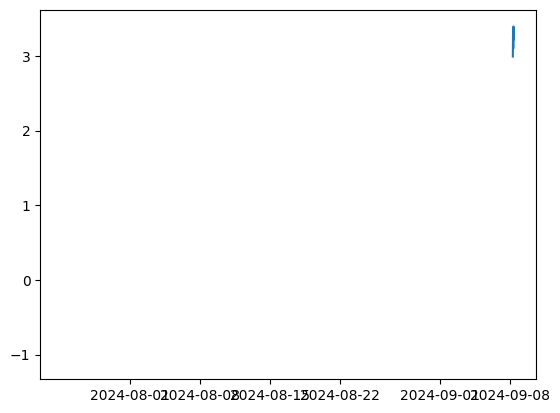

In [54]:
import matplotlib.pyplot as plt
importlib.reload(dbPipeline)
path = r'test\database\SCL\Flux\2024'
f = dbPipeline.databaseFolder(path = path,year = 2024)
f.Data
plt.figure()
plt.plot(f.Data['Ux_mean'])
# plt.plot(f.Data['TS_1_2_1'])
# plt.plot(f.Data['TS_2_2_1'])
# plt.plot(f.Data['TS_3_2_1'])
# plt.plot(f.Data['TS_4_2_1'])

In [113]:
print(f.Data.head())

Empty DataFrame
Columns: []
Index: []


In [ ]:
sourceFile = "c:\\Users\\User\\GSC_Work\\EC_dataPipeline\\example_data\\20240912\\Flux_Data2628.dat"
import pandas as pd
import numpy as np
import re
import rawDataFile
importlib.reload(rawDataFile)
import datetime
import pandas as pd
from dataclasses import dataclass, field
import helperFunctions as helper

# f = rawDataFile.TOB3(sourceFile=sourceFile,readData=True)
# f.Agg

f.Timestamp[-1]
# f.Agg

# missing = pd.to_datetime(f.Timestamp[np.isnan(f.Data).max(axis=1)],unit='s')
# print(missing.shape[0],missing.shape[0]/f.Data.shape[0])
# print(missing)

In [ ]:
f.fileTimestamp.strftime('%Y-%m-%dT%H:%M:%S')

In [ ]:
# This works:
from dataclasses import dataclass
@dataclass(kw_only=True)
class test:
  a: str
  b: str
i = {1:{'a':'a','b':'b'},2:{'a':'a','b':'b'}}
x = map(lambda kwargs: test(**kwargs),i.values())
print(list(x))

# but this doesn't
from dataclasses import dataclass
@dataclass(kw_only=True)
class test:
  name: int
  a: str
  b: str
i = {1:{'a':'a','b':'b'},2:{'a':'a','b':'b'}}
x = map(lambda name: test(name=name,**i[name]),i.keys())
print(list(x))
#

In [ ]:
def myfunc(n):
  return len(n)

x = map(myfunc, ('apple', 'banana', 'cherry')) 
list(x)

In [ ]:
importlib.reload(dbPipeline)

fpath = r'example_data\projectInventory_Template.yml'
sourcePath = r'example_data'
dbPipeline.projectInventory(
    projectPath=projectPath,Sites=fpath,
    fileSearch={'SCL':{'Flux':{'searchInventory':{'sourcePath':sourcePath,'wildcard':'*Flux*.dat'}},
                       'SSM_Profile':{'searchInventory':{'sourcePath':sourcePath,'wildcard':'*SSM*.csv'}},
                       'WSM_Profile':{'searchInventory':{'sourcePath':sourcePath,'wildcard':'*WSM*.csv'}},
                       }}
)

In [ ]:
importlib.reload(dbPipeline)
f = dbPipeline.database(projectPath=projectPath)
f.projectInventory(Sites = {'FIL':{'siteID':'FIL'}})


In [ ]:
import os
import shutil
import cleanDev as cD
import importlib
importlib.reload(cD)

projectPath = os.path.join(os.getcwd(),'test')
# try:
#     shutil.rmtree(projectPath)
# except:
#     pass

fpath = r'example_data\projectInventory_Template.yml'
sourcePath = r'example_data'
cD.projectInventory(
    projectPath=projectPath,Sites=fpath,
    # fileSearch={'SCL':{'Flux':{'searchInventory':{'sourcePath':sourcePath,'wildcard':'*Flux*.dat'}}}}
        # 'SCL':{
        #     'SSM_Profile':cD.Source(sourcePath=sourcePath,fileExt='csv',matchPattern=['SSM','readout'],fileType='HOBOcsv').__dict__,
        #     'WSM_Profile':cD.Source(sourcePath=sourcePath,fileExt='csv',matchPattern=['WSM','readout'],fileType='HOBOcsv').__dict__,
        #     'Flux':cD.Source(sourcePath=sourcePath,fileExt='dat',matchPattern=['Flux'],fileType='TOBA').__dict__}}
)


In [ ]:
importlib.reload(cD)
# cD.searchInventory(
#     projectPath=projectPath,
#     siteID='SCL',
#     measurementID='Flux',
#     searchInventory={
#     'sourcePath':r'example_data',
#     'fileType':'HOBOcsv',
#     'fileExt':'csv',
#     'matchPattern':['20240724','SSM','readout']
#     })
cD.searchInventory(
    projectPath=projectPath,
    siteID='SCL',
    measurementID='Flux',
    searchInventory={
    'sourcePath':r'example_data',
    'wildcard':'*Flux*.dat',
    })

In [ ]:
import fnmatch
sourcePath=r'example_data'
sourcePath=os.path.abspath(sourcePath)
for dir,_,fn in os.walk(sourcePath):
   #  subDir = os.path.relpath(dir,sourcePath)
    print([os.path.join(dir,f) for f in fn 
           if fnmatch.fnmatch(os.path.join(sourcePath,f),os.path.join(sourcePath+'*'))
        #    and not fnmatch.fnmatch(os.path.join(subDir,f),'202409*SSM*readout*.csv')
           ])

In [ ]:

cD.Search().uID

In [ ]:
from dataclasses import dataclass, field
import helperFunctions as helper
@dataclass
class fileSearch:
    sourceID: str = 'sourceID'
    fileType: str = None
    fileExt: str = None
    sourcePath: str = None
    matchPattern: list = field(default_factory=lambda:[])
    excludePattern: list = field(default_factory=lambda:[])
    
    def __post_init__(self):
        self.sourceID = helper.safeFmt(self.sourceID)
        for f,v in self.__dataclass_fields__.items():
            if v.type is list:
                if type(self.__dict__[f]) is not list:
                    self.__dict__[f] = [self.__dict__[f]]
        if self.sourcePath:
            self.sourcePath = os.path.abspath(self.sourcePath)
        pass

@dataclass
class sourceFiles:
    siteID: str
    measurementID: str
    sourceFiles: fileSearch

    def __post_init__(self):
        if type(list(self.sourceFiles.values())[0]) is dict:
            self.sourceFiles = {fileSearch(**value).sourceID:fileSearch(**value).__dict__ for key,value in self.sourceFiles.items()}
        else:
            self.sourceFiles = {fileSearch(**self.sourceFiles).sourceID:fileSearch(**self.sourceFiles).__dict__}

data = {'siteID': 'SCL', 'measurementID': 'Flux', 'sourceFiles': {'sourceID':'X'}}

print(sourceFiles(**data))

In [ ]:
import os
import shutil
import importlib
import NewDev as ND
import helperFunctions
importlib.reload(ND)  
importlib.reload(helperFunctions)   

# # fresh database
projectPath = os.path.join(os.getcwd(),'test')
try:
    shutil.rmtree(projectPath)
except:
    pass

sites = helperFunctions.loadDict('example_data/siteInventory.yml')
for site in sites.values():
    ND.siteInventory(projectPath=projectPath,**site)


# source = r'example_data'
# ND.measurementInventory(projectPath=projectPath,
#   siteID='SCL',
#   measurementID='Soil Profile',
#   pointID='SSM',
#   fileType='HOBOcsv',
#   baseFrequency='30min',
#   description = 'Soil temperature profiles in the salix sedge meadow',
#   sourceInventory={
#     '20240724':{
#         'sourcePath':source,
#         'sourceID':'20240724',
#         'matchPattern':['20240724','SSM','readout'],
#         'fileExt':'csv'},
#     '20240914':{
#         'sourcePath':source,
#         'sourceID':'20240914',
#         'matchPattern':['20240914','SSM','readout'],
#         'fileExt':'csv'},
#   })

## 2. Define measurments

In [ ]:

ND.measurementInventory(projectPath=projectPath,
  siteID='SCL',
  measurementID='Flux',
  fileType='TOBA',
  baseFrequency='50ms',
  measurementDescription = 'High frequency eddy covariance data'
  )
ND.measurementInventory(projectPath=projectPath,
  siteID='SCL',
  measurementID='Meteorologic',
  fileType='TOBA',
  baseFrequency='30min',
  measurementDescription = 'Low frequency meteorological data'
  )
ND.measurementInventory(projectPath=projectPath,
  siteID='SCL',
  measurementID='Metadata',
  fileType='TOBA',
  baseFrequency='24h',
  measurementDescription = 'Daily metadata summaries'
  )
ND.measurementInventory(projectPath=projectPath,
  siteID='SCL',
  measurementID='Soil Profile',
  subsiteID='SSM',
  fileType='HOBOcsv',
  baseFrequency='30min',
  measurementDescription = 'Soil temperature profiles in the salix sedge meadow'
  )

a = ND.measurementInventory(projectPath=projectPath,
  siteID='SCL',
  measurementID='Soil Profile',
  subsiteID='WSM',
  fileType='HOBOcsv',
  baseFrequency='30min',
  measurementDescription = 'Soil temperature profiles in the wet sedge meadow'
  )
# a.__dict__

In [ ]:
# importlib.reload(ND)
source = r'example_data\20240724'
# t = ND.searchInventory(projectPath=projectPath,
#     siteID='SCL',
#     measurementID='Soil_Profile',
#     subsiteID='SSM',
#     fileType='HOBOcsv',
#     sourcePath=source,
#     fileExt='csv',
#     matchPattern=['SSM','readout']
#     )

# t = ND.searchInventory(projectPath=projectPath,
#     siteID='SCL',
#     measurementID='Soil_Profile',
#     subsiteID='WSM',
#     fileType='HOBOcsv',
#     sourcePath=source,
#     fileExt='csv',
#     matchPattern=['WSM','readout']
#     )

# t.findNewSourceFiles()
print(os.path.abspath(source))

In [ ]:
importlib.reload(ND)
ND.database(verbose=True,projectPath=projectPath).validate()
# ND.siteInventory(projectPath=projectPath)
# any([j==1 for j in [1,2,3]])

In [ ]:
# importlib.reload(ND)
# source = r'example_data\20240724'
# t = ND.sourcefileInventory(projectPath=projectPath,
#     siteID='SCL',
#     index='Soil_Profile-WSM-HOBOcsv',
#     sourcePath=source,
#     fileExt='csv',
#     matchPattern='SSsM')
# t = ND.sourcefileInventory(projectPath=projectPath,
#     siteID='SCL',
#     index='Soil_Profile-WSM-HOBOcsv',
#     sourcePath=source,
#     fileExt='csv',
#     matchPattern='SSsM')

# source = r'example_data\20240914'
# t = ND.sourcefileInventory(projectPath=projectPath,
#     siteID='SCL',
#     index='Soil_Profile-WSM-HOBOcsv',
#     sourcePath=source,
#     fileExt='csv',
#     matchPattern='SSM')
# # t.subIndex

In [ ]:
# 
# tuple(['a','b'])
tuple(['ab'])

## Setup an inventory

In [ ]:
import os
import yaml
import time
import shutil
import numpy as np
import pandas as pd
import importlib
import NewDev as ND
import helperFunctions as hf
importlib.reload(ND)     

# fresh database
projectPath = os.path.join(os.getcwd(),'test')
try:
    shutil.rmtree(projectPath)
except:
    pass
# ND.databaseProject(projectPath)

# load templates
template = hf.loadDict(r'example_data\siteInventory.yml')
for siteID,values in template.items():
    print(values)
    ND.siteInventory(projectPath=projectPath,**values)

template = hf.loadDict(r'example_data\SCL\measurementInventory.yml')
for measurementID,values in template.items():
    ND.measurementInventory(projectPath=projectPath,measurementID=measurementID,siteID='SCL',**values)

source = r'example_data'
ND.fileInventory(projectPath=projectPath,source=source,siteID='SCL',measurementID='Profile_SSM',ext='csv',matchPattern='SSM')#,lookup=True)
ND.fileInventory(projectPath=projectPath,source=source,siteID='SCL',measurementID='Profile_WSM',ext='csv',matchPattern='WSM')#,lookup=True)

In [ ]:
# ND.fileInventory(projectPath=projectPath,siteID='SCL',measurementID='Profile_WSM',lookup=True).sessionMetadata
# # a = None
# # if a:
# #     print('d')
d={['1','2']:'x'}

## File Management

In [ ]:
import time
import rawDataFile_bu2 as rd
importlib.reload(rd)
source = r'example_data'
T1 = time.time()

t = rd.fileInventory(projectPath=projectPath,source=source,siteID='SCL',measurementID='Profile_SSM',ext='csv',matchPattern='SSM',lookup=True)

t.inventory

In [ ]:
import pandas as pd
pd.date_range('2025-03-01','2025-03-02',freq='50ms')

In [ ]:
# fn
import os
import rawDataFile_bu2 as rawDataFile_bu2
importlib.reload(rawDataFile_bu2)
# fn = fi['SCL']['TS_Profile-WSM']['c:\\Users\\jskeeter\\gsc-permafrost\\SCL_2024']['sourceFiles'][0]
# fn = os.path.join('c:\\Users\\jskeeter\\gsc-permafrost\\SCL_2024',fn)
fn = r'c:\\Users\\jskeeter\\gsc-permafrost\\SCL_2024\\20240724\\20750527-SHSC.WSM.SGT.240720_240724readout.csv'
rd = rawDataFile_bu2.hoboCSV(projectPath=projectPath,source=fn,siteID='SCL',measurementType='TS_Profile',loggerID='WSM',
                         Metadata='test.yml')

with open('test.yml','w+') as f:
    yaml.safe_dump(rd.Metadata,f,sort_keys=False)

# Database

In [ ]:
importlib.reload(ND)

# projectPath = os.path.join(os.getcwd(),'test2')
# # if os.path.isdir(projectPath):
# #     shutil.rmtree(projectPath)

# db = pyDB.database(projectPath=projectPath)
# # db = pyDB.database(projectPath=projectPath,
# #     # siteID=['SCL'],
# #     # Years=[str(y) for y in range(2024,2025)],
# #     # verbose=False
# #     )
# # db.
n = ND.rawDatabaseImport(projectPath=projectPath,measurementID ='test',dataIn=rd.Data,metadataIn=rd.Metadata)

n

In [ ]:

# siteFields = set(self.__dataclass_fields__) - {f for base in siteRecord.__bases__ if hasattr(base,'__dataclass_fields__') for f in base.__dataclass_fields__}
# siteFields = set(self.__dataclass_fields__) - {f for base in origin.__bases__ if hasattr(base,'__dataclass_fields__') for f in base.__dataclass_fields__}


def baseFields(self,repr=True,orderd=True):
    X = (set(self.__dataclass_fields__) - {f for base in type(self).__bases__ if hasattr(base,'__dataclass_fields__') for f,v in base.__dataclass_fields__.items() if v.repr==repr})
    print(X)
    print([k for k in self.__dataclass_fields__ if k in X])


from dataclasses import dataclass, field
@dataclass
class A:
    b: int = field(default=2,repr=False)
    j: int = 1

@dataclass
class B(A):
    x: str = 'a'
    b: int = field(default=3,repr=False)
    y: str = 'a'

baseFields(B())